In [2]:
# --+ loading libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import geopandas as gpd
import plotly.graph_objects as go
#import geoplot as gplt
import statsmodels.tsa.stattools as stattools
import math
import plotly.graph_objects as go
import plotly
import plotly.graph_objs as go
from shapely.geometry import Point
from plotly.subplots import make_subplots
from plotly.offline import *

In [3]:
data = pd.read_csv('BasicCompanyDataAsOneFile-2021-12-01.csv')
postcodes = pd.read_csv('postcodes.csv')

/var/folders/gq/bllqt9gj1bq5wzshmf8x9wcw0000gn/T/ipykernel_10047/829712140.py:1: DtypeWarning:

Columns (41,42,43,44,45,46,47,48,49,50,51,52) have mixed types. Specify dtype option on import or set low_memory=False.

/var/folders/gq/bllqt9gj1bq5wzshmf8x9wcw0000gn/T/ipykernel_10047/829712140.py:2: DtypeWarning:

Columns (7,17,18,21,22,24,25,29,32,39,47) have mixed types. Specify dtype option on import or set low_memory=False.



Pre-processing and data cleaning

In [4]:
# dropping unncessary columns
data = data.drop([
    'RegAddress.CareOf', 'RegAddress.POBox', 'RegAddress.County',
    'DissolutionDate', 'PreviousName_1.CONDATE', ' PreviousName_1.CompanyName',
    ' PreviousName_2.CONDATE', ' PreviousName_2.CompanyName',
    'PreviousName_3.CONDATE', ' PreviousName_3.CompanyName',
    'PreviousName_4.CONDATE', ' PreviousName_4.CompanyName',
    'PreviousName_5.CONDATE', ' PreviousName_5.CompanyName',
    'PreviousName_6.CONDATE', ' PreviousName_6.CompanyName',
    'PreviousName_7.CONDATE', ' PreviousName_7.CompanyName',
    'PreviousName_8.CONDATE', ' PreviousName_8.CompanyName',
    'PreviousName_9.CONDATE', ' PreviousName_9.CompanyName',
    'PreviousName_10.CONDATE', ' PreviousName_10.CompanyName',
    'ConfStmtNextDueDate', ' ConfStmtLastMadeUpDate',
    'Mortgages.NumMortOutstanding', 'Mortgages.NumMortPartSatisfied',
    'Mortgages.NumMortSatisfied', 'SICCode.SicText_2', 'SICCode.SicText_3',
    'SICCode.SicText_4', 'LimitedPartnerships.NumGenPartners',
    'LimitedPartnerships.NumLimPartners'
],
                 axis=1)

In [5]:
# keeping only England companies
data = data[(data["RegAddress.Country"] == "ENGLAND")]

In [6]:
# --+ dropping NA
data = data.dropna(subset=['SICCode.SicText_1'])

In [7]:
# removing dormant companies
data = data[data["SICCode.SicText_1"] != "99999 - Dormant Company"]

In [8]:
# removing none supplied option
data = data[data["SICCode.SicText_1"] != "None Supplied"]

In [9]:
# keeping only the first digits of the SIC code (2 digits)
data = data.loc[data["SICCode.SicText_1"].notnull()]

In [10]:
data.loc[:, "2digSIC"] = data["SICCode.SicText_1"].str[0:2]

In [11]:
# general sum of the SIC codes of every company
data["Number_of_SIC"] = 4 - (data[["SICCode.SicText_1"]].isnull().sum(axis=1))

In [12]:
# changing the astype of our column
Sic1 = data['2digSIC'].to_numpy()
Sic1 = Sic1.astype(str).astype(int)
data['Sic2DigNum'] = Sic1

In [13]:
def SICtoIndustry(SICCode):
    if SICCode in [i for i in range(1, 4)]:
        SICCode = "Agriculture, Forestry and Fishing"
    elif SICCode in [i for i in range(5, 10)]:
        SICCode = "Mining and Quarrying"
    elif SICCode in [i for i in range(10, 34)]:
        SICCode = "Manufacturing"
    elif SICCode == 35:
        SICCode = "Electricity, gas, steam and air conditioning supply"
    elif SICCode in [i for i in range(36, 40)]:
        SICCode = "Water supply, sewerage, waste management and remediation activities"
    elif SICCode in [i for i in range(41, 44)]:
        SICCode = "Construction"
    elif SICCode in [i for i in range(45, 48)]:
        SICCode = "Wholesale and retail trade; repair of motor vehicles and motorcycles"
    elif SICCode in [i for i in range(49, 54)]:
        SICCode = "Transportation and storage"
    elif SICCode in [i for i in range(55, 57)]:
        SICCode = "Accommodation and food service activities"
    elif SICCode in [i for i in range(58, 64)]:
        SICCode = "Information and communication"
    elif SICCode in [i for i in range(64, 67)]:
        SICCode = "Financial and insurance activities"
    elif SICCode == 68:
        SICCode = "Real estate activities"
    elif SICCode in [i for i in range(69, 76)]:
        SICCode = "Professional, scientific and technical activities"
    elif SICCode in [i for i in range(77, 83)]:
        SICCode = "Administrative and support service activities"
    elif SICCode == 84:
        SICCode = "Public administration and defence; compulsory social security"
    elif SICCode == 85:
        SICCode = "Education"
    elif SICCode in [i for i in range(86, 89)]:
        SICCode = "Human health and social work activities"
    elif SICCode in [i for i in range(90, 94)]:
        SICCode = "Arts, entertainment and recreation"
    elif SICCode in [i for i in range(94, 97)]:
        SICCode = "Other service activities"
    elif SICCode in [i for i in range(97, 99)]:
        SICCode = "Activities of households as employers; undifferentiated goods- and services-producing activities of households for own use"
    elif SICCode == 99:
        SICCode = "Activities of extraterritorial organisations and bodies"
    else:
        SICCode = np.NAN
    return SICCode

In [14]:
# --+ applying the function
data["SIC_1_Industry"] = data["Sic2DigNum"].apply(SICtoIndustry)

In [15]:
# london dataset
london = data[((data["RegAddress.PostTown"] == "GREATER LONDON") |
               (data["RegAddress.PostTown"] == "LONDON"))]

In [16]:
# --+ dropping NA
london = london.dropna(subset=['SICCode.SicText_1'])

In [17]:
# removing dormant companies
london = london[london["SICCode.SicText_1"] != "99999 - Dormant Company"]

In [18]:
# removing none supplied option
london = london[london["SICCode.SicText_1"] != "None Supplied"]

In [19]:
# keeping only the first digits of the SIC code (2 digits)
london = london.loc[london["SICCode.SicText_1"].notnull()]

In [20]:
london.loc[:, "2digSIC"] = london["SICCode.SicText_1"].str[0:2]

In [21]:
# general sum of the SIC codes of every company
london["Number_of_SIC"] = 4-(london[["SICCode.SicText_1"]].isnull().sum(axis=1))

In [22]:
# changing the astype of our column
Sic1 = london['2digSIC'].to_numpy()
Sic1 = Sic1.astype(str).astype(int)
london['Sic2DigNum'] = Sic1

In [23]:
# --+ applying the function
london["SIC_1_Industry"] = london["Sic2DigNum"].apply(SICtoIndustry)

In [24]:
# --+ transforming date
london['IncorporationDate'] = pd.to_datetime(london['IncorporationDate'], errors = 'coerce')

/var/folders/gq/bllqt9gj1bq5wzshmf8x9wcw0000gn/T/ipykernel_10047/3269235707.py:2: UserWarning:

Parsing '23/02/2021' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.

/var/folders/gq/bllqt9gj1bq5wzshmf8x9wcw0000gn/T/ipykernel_10047/3269235707.py:2: UserWarning:

Parsing '23/11/2016' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.

/var/folders/gq/bllqt9gj1bq5wzshmf8x9wcw0000gn/T/ipykernel_10047/3269235707.py:2: UserWarning:

Parsing '21/08/1985' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.

/var/folders/gq/bllqt9gj1bq5wzshmf8x9wcw0000gn/T/ipykernel_10047/3269235707.py:2: UserWarning:

Parsing '30/11/2011' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.

/var/folders/gq/bllqt9gj1bq5wzshmf8x9wcw0000gn/T/ipykernel_10047/3269235707.py:2: UserWarning:

Parsing '20/07/2016' in DD/MM/YYYY f

In [25]:
# --+ adding new column year
london["IncorporationYear"] = london["IncorporationDate"].apply(lambda x: str(x.year))

In [26]:
# --+ keeping companies since 2019
london = london[london.IncorporationYear >= "2019"]

In [27]:
london = london.drop([
    'Mortgages.NumMortCharges', 'URI', 'Returns.LastMadeUpDate',
    'Returns.NextDueDate', 'Accounts.AccountCategory',
    'Accounts.LastMadeUpDate', 'Accounts.NextDueDate',
    'Accounts.AccountRefMonth', 'Accounts.AccountRefDay', 'CompanyStatus',
    'CompanyCategory'
],
                     axis=1)

In [28]:
# --+ transforming date
data['IncorporationDate'] = pd.to_datetime(data['IncorporationDate'],
                                           errors='coerce')

/var/folders/gq/bllqt9gj1bq5wzshmf8x9wcw0000gn/T/ipykernel_10047/1948018142.py:2: UserWarning:

Parsing '17/05/2021' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.

/var/folders/gq/bllqt9gj1bq5wzshmf8x9wcw0000gn/T/ipykernel_10047/1948018142.py:2: UserWarning:

Parsing '30/07/2014' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.

/var/folders/gq/bllqt9gj1bq5wzshmf8x9wcw0000gn/T/ipykernel_10047/1948018142.py:2: UserWarning:

Parsing '23/02/2021' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.

/var/folders/gq/bllqt9gj1bq5wzshmf8x9wcw0000gn/T/ipykernel_10047/1948018142.py:2: UserWarning:

Parsing '23/08/2006' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.

/var/folders/gq/bllqt9gj1bq5wzshmf8x9wcw0000gn/T/ipykernel_10047/1948018142.py:2: UserWarning:

Parsing '29/07/2014' in DD/MM/YYYY f

In [29]:
# --+ adding new column year
data["IncorporationYear"] = data["IncorporationDate"].apply(
    lambda x: str(x.year))

In [30]:
# --+ adding new column month-year
data["IncorporationMonth"] = data["IncorporationDate"].apply(lambda x: str(
    x.year)) + "-" + data["IncorporationDate"].apply(lambda x: str(x.month))

In [31]:
# --+ keeping companies since 2019
data = data[data.IncorporationDate >= "01/01/2019"]

In [32]:
# --+ Pre-covid data, first national lockdown took place at 23th March 2020
pre_covid_london = london[london.IncorporationDate < "23/03/2020"]

/Users/georgekalfas/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:48: UserWarning:

Parsing '23/03/2020' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.



In [33]:
# --+ after lockdown data
covid_london = london[london.IncorporationDate >= "23/03/2020"]

/Users/georgekalfas/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:60: UserWarning:

Parsing '23/03/2020' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.



In [34]:
# --+ preparing new dataset based on the postcodes.csv file
x = data.copy()
y = postcodes[[
    'Postcode', 'County', 'Country', 'Latitude', 'Longitude', 'London zone'
]]

In [35]:
# --+ combining the two CSVs
combined_df = pd.merge(x,
                       y,
                       how='left',
                       left_on='RegAddress.PostCode',
                       right_on='Postcode')

In [36]:
# --+ creating a new data csv file
combined_df = combined_df[~combined_df["Country"].isnull()]
combined_df = combined_df[(combined_df['Latitude'] != 0)
                          & (combined_df['Longitude'] != 0)]
combined_df.drop(columns=["RegAddress.PostCode"], inplace=True)
combined_df.to_csv('cleaned_data.csv', index=False)

In [37]:
# --+ getting geometry points
points = []
for lon, lat in zip(combined_df["Longitude"], combined_df["Latitude"]):
    points.append(Point(lon, lat))

In [38]:
# --+ adding new column
combined_df["geometry"] = points

In [39]:
# --+ geodataframe
combined_df = gpd.GeoDataFrame(combined_df)

Pre-processing for every different Industry

In [40]:
# --+
NumberOfCompaniesSameIndustry = pd.DataFrame(
    combined_df['SIC_1_Industry'].value_counts())

In [41]:
# --+ smaller Industries
smallerIndustries = NumberOfCompaniesSameIndustry.sort_values(
    by=['SIC_1_Industry']).head(5)

In [42]:
# --+ largest Industries
biggestIndustries = NumberOfCompaniesSameIndustry['SIC_1_Industry'].nlargest(
    n=5)

In [43]:
# --+ dataframe with smallest Industries regarding the number of opening
df_small = combined_df[(
    (combined_df["SIC_1_Industry"]
     == 'Public administration and defence; compulsory social security') |
    (combined_df["SIC_1_Industry"]
     == "Water supply, sewerage, waste management and remediation activities")
    | (combined_df["SIC_1_Industry"]
       == 'Electricity, gas, steam and air conditioning supply') |
    (combined_df["SIC_1_Industry"] == 'Mining and Quarrying') |
    (combined_df["SIC_1_Industry"]
     == 'Activities of extraterritorial organisations and bodies'))]

In [44]:
# --+ dataframe largest Industries
df_large = combined_df[(
    (combined_df["SIC_1_Industry"]
     == 'Wholesale and retail trade; repair of motor vehicles and motorcycles')
    | (combined_df["SIC_1_Industry"] == "Construction") |
    (combined_df["SIC_1_Industry"]
     == 'Professional, scientific and technical activities') |
    (combined_df["SIC_1_Industry"] == 'Real estate activities') |
    (combined_df["SIC_1_Industry"] == 'Information and communication'))]

In [45]:
# --+ grouping by SIC_1_Industry and IncorporationYear LARGE
df_large_year = df_large.groupby(['SIC_1_Industry',
                                  'IncorporationYear']).count()
df_large_year.reset_index(inplace=True)

In [46]:
# --+ grouping by SIC_1_Industry and IncorporationMonth LARGE
df_large_month = df_large.groupby(['SIC_1_Industry',
                                   'IncorporationMonth']).count()
df_large_month.reset_index(inplace=True)

In [47]:
# --+ grouping by SIC_1_Industry and IncorporationYear SMALL
df_small_year = df_small.groupby(['SIC_1_Industry',
                                  'IncorporationYear']).count()
df_small_year.reset_index(inplace=True)

In [48]:
# --+ grouping by SIC_1_Industry and IncorporationMonth SMALL
df_small_month = df_small.groupby(['SIC_1_Industry',
                                   'IncorporationMonth']).count()
df_small_month.reset_index(inplace=True)

In [49]:
# --+ df small companies necessary columns
smallindustries = df_small_month[[
    'SIC_1_Industry', 'IncorporationMonth', 'CompanyName'
]]

In [50]:
# --+ converting datetime for small industries
smallindustries['IncorporationMonth'] = pd.to_datetime(
    smallindustries['IncorporationMonth'], errors='coerce')

/var/folders/gq/bllqt9gj1bq5wzshmf8x9wcw0000gn/T/ipykernel_10047/168297108.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [51]:
# --+ sorting by month and year
smallindustries = smallindustries.sort_values(by=['IncorporationMonth'])

In [52]:
# --+ largeindustries dataframe
largeindustries = df_large_month[[
    'SIC_1_Industry', 'IncorporationMonth', 'CompanyName'
]]

In [53]:
# --+ converting datetime for large industries
largeindustries['IncorporationMonth'] = pd.to_datetime(
    largeindustries['IncorporationMonth'], errors='coerce')

/var/folders/gq/bllqt9gj1bq5wzshmf8x9wcw0000gn/T/ipykernel_10047/540718504.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [54]:
# --+ sorting by month and year
largeindustries = largeindustries.sort_values(by=['IncorporationMonth'])

Continue to pre-processing for 2nd and 3rd graph

In [55]:
# --+ LONDON DATASET FOR PLOT SPECIFIC SECTORS
df_london = london[(
    (london["SIC_1_Industry"]
     == 'Wholesale and retail trade; repair of motor vehicles and motorcycles')
    | (london["SIC_1_Industry"] == "Construction") |
    (london["SIC_1_Industry"]
     == 'Professional, scientific and technical activities') |
    (london["SIC_1_Industry"] == 'Real estate activities') |
    (london["SIC_1_Industry"] == 'Information and communication'))]

In [56]:
# --+ grouping by SIC_1_Industry and IncorporationYear LARGE
df_london_year = df_london.groupby(['SIC_1_Industry',
                                    'IncorporationYear']).count()
df_london_year.reset_index(inplace=True)

In [57]:
# --+ large industries dataframe
london_for_use = df_london_year[[
    'SIC_1_Industry', 'IncorporationYear', 'CompanyName'
]]

In [58]:
# Calculating Percentage
london_for_use['percent'] = (london_for_use['CompanyName'] /
                             london_for_use['CompanyName'].sum()) * 100

/var/folders/gq/bllqt9gj1bq5wzshmf8x9wcw0000gn/T/ipykernel_10047/3745325567.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [59]:
# --+ graph 3 cleaning datasets
graph3_df = combined_df.drop([
    'RegAddress.AddressLine1', 'RegAddress.PostTown', 'CompanyStatus',
    'IncorporationDate', 'Accounts.AccountRefDay', 'Accounts.AccountRefMonth',
    'Accounts.LastMadeUpDate', 'Accounts.AccountCategory',
    'Returns.LastMadeUpDate', 'Mortgages.NumMortCharges', 'SICCode.SicText_1',
    'URI', 'Number_of_SIC', 'IncorporationMonth', 'London zone'
],
                             axis=1)

In [60]:
# --+ keeping companies since 2019
graph3_df = graph3_df[graph3_df.IncorporationYear >= "2019"]

In [61]:
# --+ focusing on one specific sector
graph3_df = graph3_df[graph3_df.SIC_1_Industry == "Real estate activities"]

# 1st Graph
### Line graph comparing the number of companies opening before and after the lockdowns

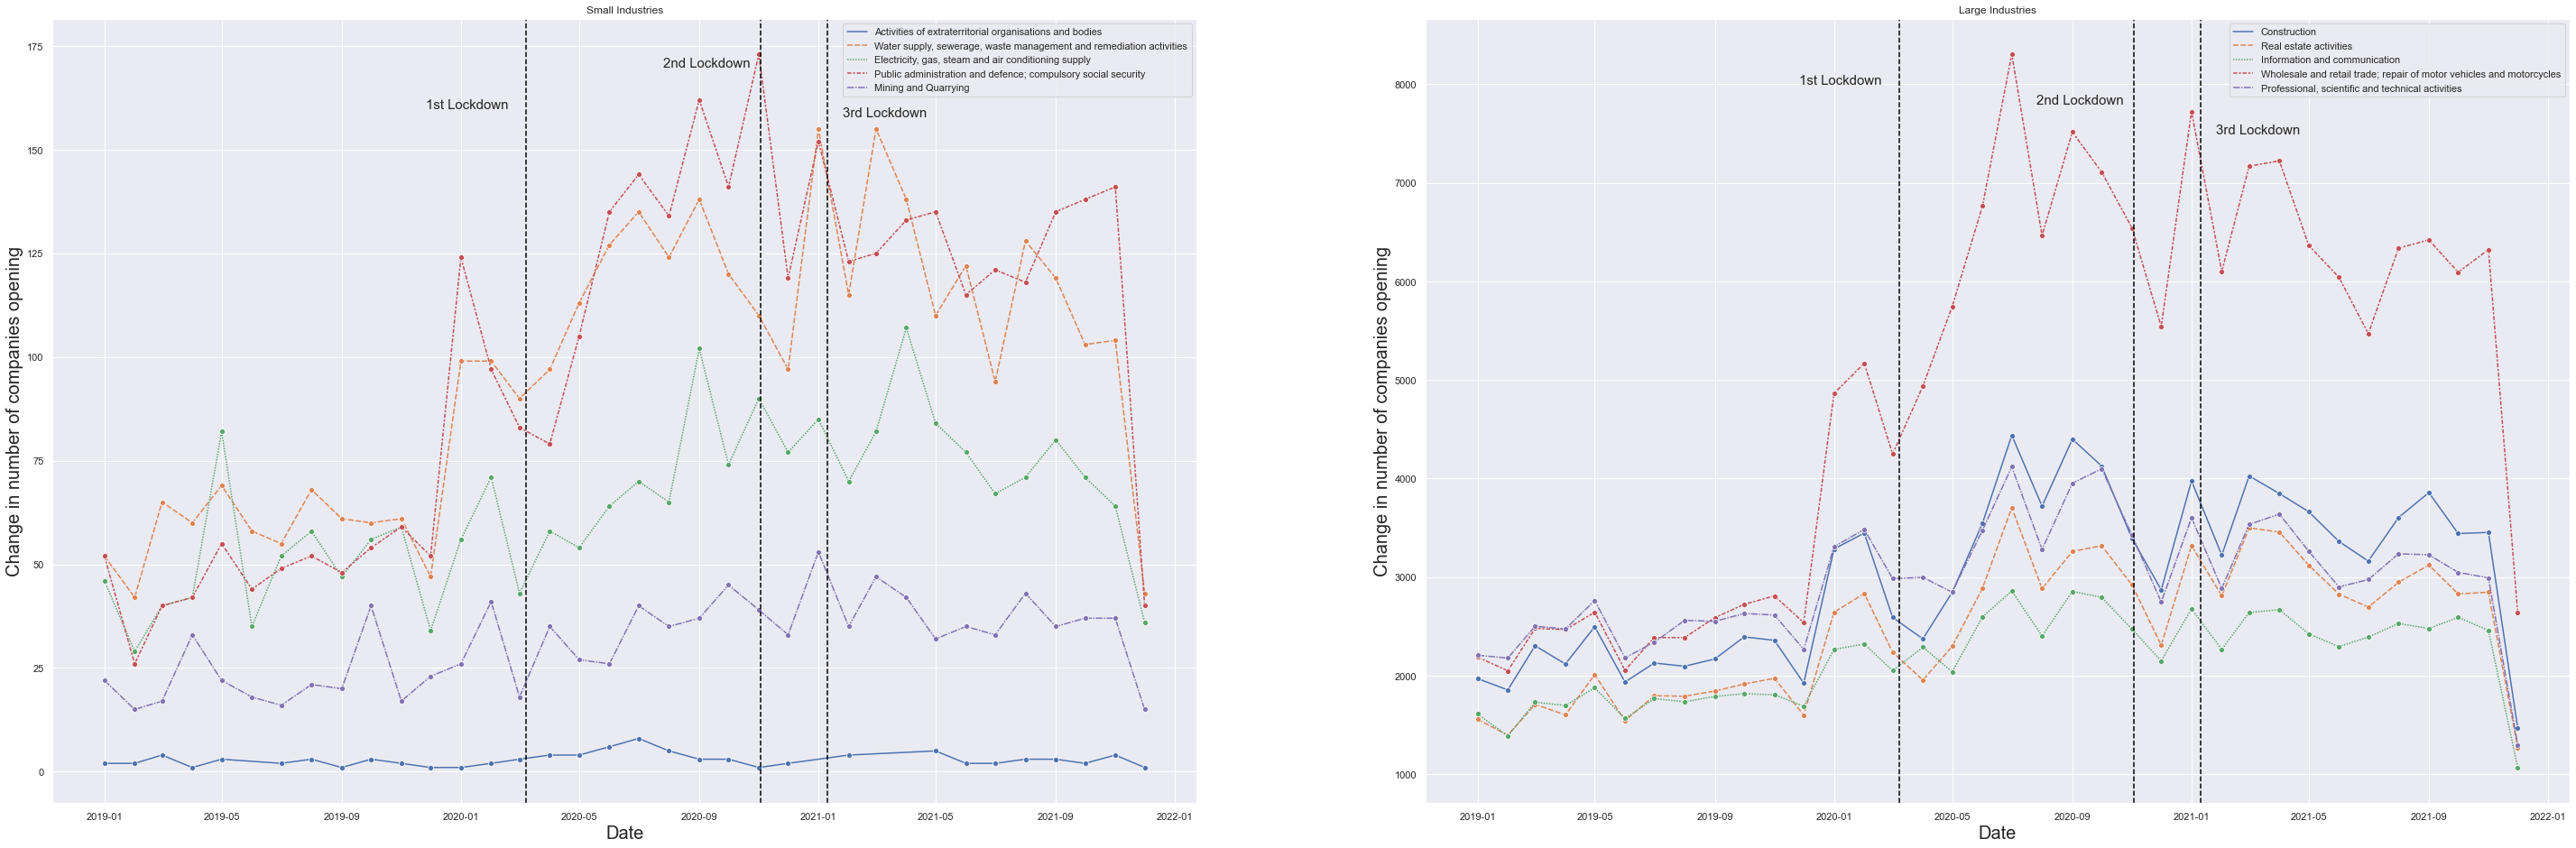

In [62]:
sns.set(rc={'figure.figsize': (50, 16)})
ax = plt.subplot(1, 2, 1)
ax1 = plt.subplot(1, 2, 2)

z = sns.lineplot(data=smallindustries,
                 x='IncorporationMonth',
                 y='CompanyName',
                 hue='SIC_1_Industry',
                 style='SIC_1_Industry',
                 marker="o",
                 ax = ax)
z.axvline(pd.to_datetime('2020-03-08'), color='black', linestyle='--')
z.annotate('1st Lockdown',
           xy=((pd.to_datetime('2019-11-26')), 160),
           fontsize=15)
z.axvline(pd.to_datetime('2020-11-03'), color='black', linestyle='--')
z.annotate('2nd Lockdown',
           xy=((pd.to_datetime('2020-07-26')), 170),
           fontsize=15)
z.axvline(pd.to_datetime('2021-01-10'), color='black', linestyle='--')
z.annotate('3rd Lockdown',
           xy=((pd.to_datetime('2021-01-26')), 158),
           fontsize=15)
z.legend(bbox_to_anchor=(1.0, 1), loc='best')
z.set_title('Small Industries')
z.set_xlabel("Date", fontsize=20)
z.set_ylabel("Change in number of companies opening", fontsize=20)

p = sns.lineplot(data=largeindustries,
                 x='IncorporationMonth',
                 y='CompanyName',
                 hue='SIC_1_Industry',
                 style='SIC_1_Industry',
                 marker="o",
                 ax = ax1)
p.axvline(pd.to_datetime('2020-03-08'), color='black', linestyle='--')
p.annotate('1st Lockdown',
           xy=((pd.to_datetime('2019-11-26')), 8000),
           fontsize=15)
p.axvline(pd.to_datetime('2020-11-03'), color='black', linestyle='--')
p.annotate('2nd Lockdown',
           xy=((pd.to_datetime('2020-07-26')), 7800),
           fontsize=15)
p.axvline(pd.to_datetime('2021-01-10'), color='black', linestyle='--')
p.annotate('3rd Lockdown',
           xy=((pd.to_datetime('2021-01-26')), 7500),
           fontsize=15)
p.legend(bbox_to_anchor=(1.0, 1), loc='best')
p.set_title('Large Industries')
p.set_xlabel("Date", fontsize=20)
p.set_ylabel("Change in number of companies opening", fontsize=20)

plt.show()

# 2nd Graph
Bar chart from London largest industries | and the difference of increase/decrease in new corporations from 2019-2021

In [63]:
labels = [
    'Construction', 'Information and communication', 'Professional activities',
    'Real estate', 'Wholesale and retail'
]
values19 = [4264, 6403, 7195, 4654, 6979]
values20 = [7445, 10301, 11041, 7825, 18335]
values21 = [7537, 10739, 10606, 9503, 20569]

c = []

i = 0

while i < len(values19):
    i = i
    if values19[i] > values20[i]:
        q = values19[i] - values20[i]
        c.append('-' + str(math.floor(q / values19[i] * 100)) + '%')
        i = i + 1
    if values19[i] < values20[i]:
        t = values20[i] - values19[i]
        c.append('+' + str(math.floor(t / values19[i] * 100)) + '%')
        i = i + 1

c1 = []

j = 0

while j < len(values20):
    j = j
    if values20[j] > values21[j]:
        q = values20[j] - values21[j]
        c1.append('-' + str(math.floor(q / values20[j] * 100)) + '%')
        j = j + 1
    if values20[j] < values21[j]:
        t = values21[j] - values20[j]
        c1.append('+' + str(math.floor(t / values20[j] * 100)) + '%')
        j = j + 1

trace1 = go.Bar(x=labels, y=values19, name='2019')
trace2 = go.Bar(x=labels, y=values20, name='2020', text=c)
trace3 = go.Bar(x=labels, y=values21, name='2021', text=c1)

data = [trace1, trace2, trace3]
layout = go.Layout(
    barmode='group',
    title='New Incorporations in London',
)
fig = go.Figure(data=data, layout=layout)
iplot(fig)
fig.write_html('New Incorporations in London.html')

3rd Graph 
New Incorporations in a 3 year span (2019-2021) of 'Real estate activities' in the UK 

In [64]:
fig = px.scatter_mapbox(graph3_df,
                        lat='Latitude',
                        lon='Longitude',
                        opacity=0.25,
                        center=dict(lat=52.64, lon=-1.13),
                        zoom=5,
                        color='IncorporationYear',
                        mapbox_style="open-street-map",
                        title="Real estate activities",
                        width=800,
                        height=800)

fig.show()
fig.write_html('Real estate activities the past three years.html')